In [2]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) # as_frame=True 일 경우 Pandas dataframe 반환
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,  y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

그림 저장: some_digit_plot


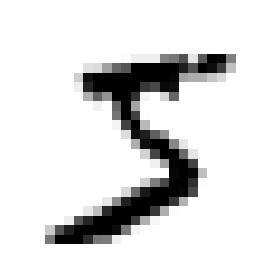

In [6]:
some_digit = X[0] # as_frame=True 일 경우 X.to_numpy()[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [115]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

# 교차 검증

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # cv : 교차 검증 폴드 수

array([0.95035, 0.96035, 0.9604 ])

## 오차 행렬

클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것 (ex. 숫자 5의 이미지를 숫자 3으로 분류된 횟수를 알고 싶을 때 -> 오차 행렬 5행 3열)
- cross_val_predict() : k-겹 교차 검증 수행 시 각 테스트 폴드에서 얻은 예측 반환
- confusion_matrix() : 오차 행렬 반환

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [14]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기라고 가정
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## 정밀도, 재현율, F1 점수

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred), f1_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311, 0.7325171197343846)

In [16]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [17]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [18]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## 정밀도/재현율 트레이드오프
- 결정함수로 각 샘플의 점수 계산
- 이 점수가 임곗값보다 크면 양성 클래스, 그렇지 않으면 음성 클래스
- 임곗값을 조절하여 정밀도/재현율 트레이드오프
- 임곗값 높이면 정밀도 ↑, 재현율 ↓
- 임곗값 낮추면 정밀도 ↓, 재현율 ↑

In [19]:
y_scores = sgd_clf.decision_function([some_digit]) # array([2164.22030239])
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

- precision_recall_curve() 를 이용해 가능한 모든 임곗값에 대해 정밀도, 재현율 계산 가능

In [21]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
len(recalls), len(precisions), len(thresholds)

(59967, 59967, 59966)

그림 저장: precision_recall_vs_threshold


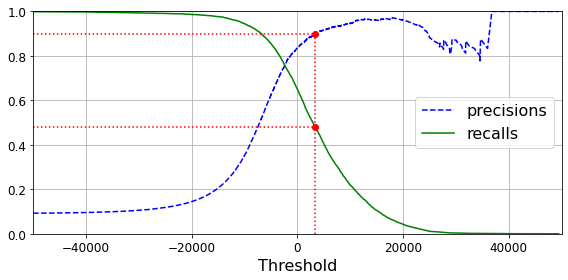

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precisions") # 개수 안맞아서 하나 빼줌
    plt.plot(thresholds, recalls[:-1], "g-", label="recalls")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
save_fig("precision_recall_vs_threshold")
plt.show()

그림 저장: precision_vs_recall


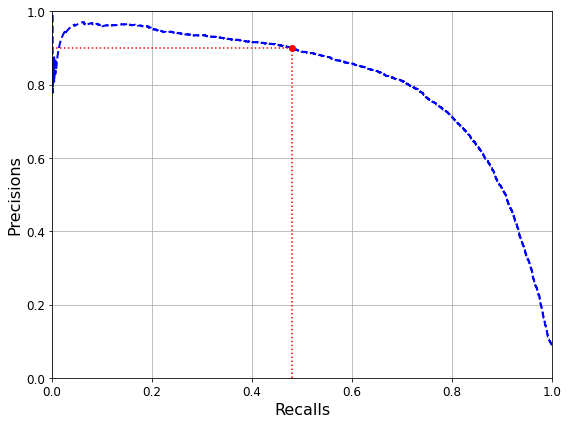

In [23]:
def plot_precision_vs_recall(precisions, recalls, thresholds):
    plt.plot(recalls, precisions, "b--", linewidth=2)
    plt.ylabel("Precisions", fontsize=16)
    plt.xlabel("Recalls", fontsize=16)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls, thresholds)
plt.plot([0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")
save_fig("precision_vs_recall")
plt.show()

### ROC 곡선
- **거짓 양성 비율**(FPR : false positive rate)에 대한 **진짜 양성 비율**(TPR : true positive rate, 재현율, 민감도)의 곡선
- **거짓 양성 비율** = 1 - **진짜 음성 비율**(TNR : true negative rate, '특이도'라고도 함)
- 즉, **민감도(재현율)에 대한 1 - 특이도 그래프**
- **곡선 아래 면적**(AUC : area under the curve) : 완벽한 분류기는 1, 완전한 랜덤 분류기는 0.5 (왼쪽 위 모서리로 향해야 함)

그림 저장: roc_curve


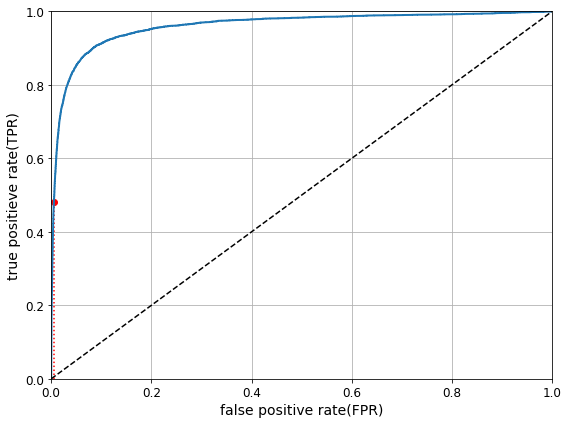

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.axis([0, 1, 0, 1]) # axis / plot
    plt.plot([0, 1],[0, 1], 'k--')
    plt.xlabel('false positive rate(FPR)')
    plt.ylabel('true positieve rate(TPR)')
    plt.grid(True)
    
plt.figure(figsize=(8,6))
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([0, fpr_90], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision], 'ro')
plot_roc_curve(fpr, tpr)
save_fig('roc_curve')
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [26]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
# RandomForestClassifier에는 decision function() 이 없고, predict_proba()가 있음. 이는 샘플이 주어진 클래스에 속할 '확률'담은 배열 반환
# predict_proba의 첫 번째 원소는 첫 번째 클래스에 대한 확률, 두 번째는 두 번째 클래스
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스 확률을 점수로 사용
y_probas_forest, y_scores_forest

(array([[0.11, 0.89],
        [0.99, 0.01],
        [0.96, 0.04],
        ...,
        [0.02, 0.98],
        [0.92, 0.08],
        [0.94, 0.06]]),
 array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06]))

그림 저장: roc_curve_SGD_vs_RandomForest


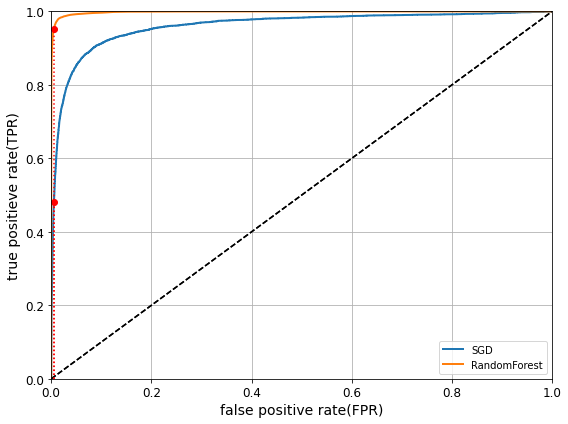

In [27]:
#roc_curve는 param으로 보통 레이블과 점수를 기대하지만, 점수 대신 클래스 확률을 받기도 함
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr, "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc='lower right')

recall_for_forest =  tpr_forest[np.argmax(fpr_forest >= fpr_90)] # 이전에 구해놨던 fpr_90을 이용함
plt.plot([0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([0, fpr_90], [recall_for_forest, recall_for_forest], "r:")
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], "r:")
plt.plot([fpr_90, fpr_90], [0, recall_for_forest], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
save_fig('roc_curve_SGD_vs_RandomForest')
plt.show()

In [28]:
roc_auc_score(y_train_5, y_scores), roc_auc_score(y_train_5, y_scores_forest)

(0.9604938554008616, 0.9983436731328145)

# 다중 분류

- SGD, 랜덤 포레스트, 나이트 베이즈 분류기 같은 일부 알고리즘은 여러 개의 클래스 직접 처리 가능
- 로지스틱 회귀, SVM(서포트 벡터 머신)은 **이진 분류**만 가능
- 이진 분류기 -> 다중 분류
    - **OvR(one-versus-the-rest)** : 특정 숫자 하나만 분류하는 이진 분류기 여러개 사용 (OvA : one-versus-all 이라고도 함)
    - **OvO(one-versus-one)** : 0과 1 구별, 0과 2 구별 등과 같이 숫자의 조합마다 이진 분류기 훈련, n개의 클래스 위해 n(n-2)/2개의 분류기 필요
    - OvO는 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요한 것이 장점
    - 일부 알고리즘(SVM)은 훈련 세트의 크기에 민감해서 OvO 선호, 대부분 OvR 선호
    - 사이킷런이 자동으로 골라서 실행

In [29]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

<a href="https://bskyvision.com/163/"/>SVC의 c와 gamma에 대하여

In [30]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [31]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

OvR, OvO 강제하려면 OneVsRestClassifier, OneVsOneClassifier 사용

In [34]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit]), len(ovr_clf.classes_)

(array([5], dtype=uint8), 10)

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [42]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 에러 분석

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

그림 저장: confusion_matrix_matshow


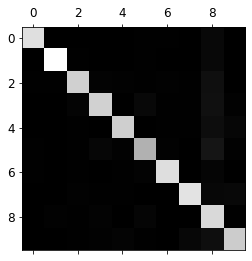

In [51]:
plt.matshow(conf_mx, cmap=plt.cm.gray) # heapmap형태로 표현
save_fig('confusion_matrix_matshow', tight_layout=False)
plt.show()

In [54]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

[axis, keepdims](https://yeko90.tistory.com/56)

에러 비율 비교 필요 (에러 개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보임)

그림 저장: confusion_matrix_errors


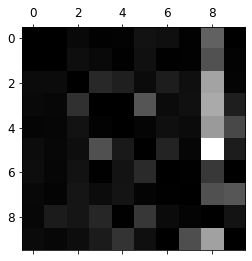

In [55]:
np.fill_diagonal(norm_conf_mx, 0) # 대각선 0으로 채움
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig('confusion_matrix_errors', tight_layout=False)
plt.show()

- 클래스 8의 열이 밝음 -> 많은 이미지들이 8로 잘못 분류
- 클래스 8의 행은 나쁘지 않음 -> 실제 8은 적절히 8로 분류
- 3과 5가 서로 많이 혼동되고 있음 (책 p150 ~ 151 참조)

## 다중 레이블 분류
- 분류기가 샘플마다 여러 개의 클래스를 출력
- 여러 개의 이진 꼬리표를 출력

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

[numpy r_() , c_()에 대하여](https://blog.lockcept.kr/73)

In [59]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [60]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## 다중 출력 분류
- 분류기의 출력이 다중 이블, 각 레이블의 값은 여러 개 가짐
- **잡음 제거 시스템 훈련 ↓**

In [129]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [130]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

그림 저장: noisy_digit_example_plot


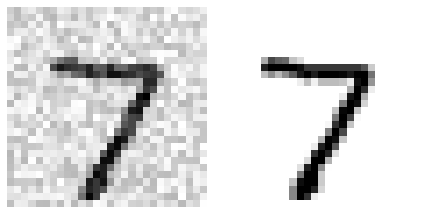

In [131]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

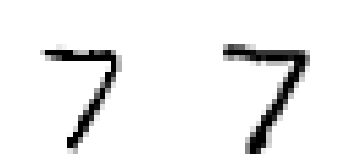

In [134]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plt.subplot(121); plot_digit(clean_digit)
plt.subplot(122); plot_digit(y_test_mod[some_index])

# 연습문제

[3]


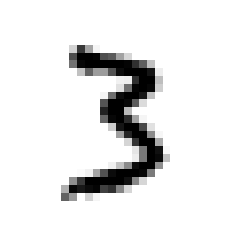

In [143]:
some_digit = X[130]
knn_clf.fit(X_train, y_train)
print(knn_clf.predict([some_digit]))
plot_digit(some_digit)

In [145]:
knn_y_train_pred = cross_val_score(knn_clf, X_train, y_train, cv=10)

In [150]:
print(knn_y_train_pred)
print(knn_clf.score(X_test, y_test))

[0.97383333 0.967      0.96816667 0.97366667 0.9705     0.97066667
 0.9695     0.969      0.96216667 0.976     ]
0.9688


In [148]:
grid_params = {
    'n_neighbors' : list(range(1,20)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

In [ ]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(knn_clf, grid_params, cv=10)
gs.fit(X_train, y_train)
gs.best_params_